In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

%matplotlib inline

Load dataset

In [2]:
df = pd.read_excel('final_analytics_takehome.xlsx')

Creating new column that provides the length of the ride in minutes

In [3]:
df['duration_minutes'] = (df.end_time - df.start_time).apply(lambda x: x.total_seconds()/60)

end_time is earlier than the start_time for a few rows in the dataset. This is an error. Lets fix it

In [4]:
bad_data = df[df.duration_minutes < 0].copy()
temp_date = bad_data.start_time

In [5]:
bad_data.start_time = bad_data.end_time
bad_data.end_time = temp_date
bad_data['duration_minutes'] = (bad_data.end_time - bad_data.start_time).apply(lambda x: x.total_seconds()/60)

In [6]:
df.loc[bad_data.index, 'start_time'] = bad_data.start_time
df.loc[bad_data.index, 'end_time'] = bad_data.end_time
df.loc[bad_data.index, 'duration_minutes'] = bad_data.duration_minutes

Save corrected data file

In [7]:
df.to_excel('corrected_dataset.xlsx',index=False)

Purging rows where duration is 0

In [8]:
df = df[df.duration_minutes > 0]

Creating column to give us the hour of day of ride. To be used later 

In [9]:
df['start_hour'] = df.start_time.dt.hour

Looking at the start and end times of each ride in the data, one thing I noticed is that they overlap. It appears that cars may make several stops to pick up and drop off other users in route to a destination. Adding a new column to dataframe that gives me the number of stops that were made during each ride.

In [10]:
ordered_df = df.sort_values(['car_id','start_time'])
ride_stops = {idx: 0 for idx in ordered_df.index}

In [11]:
for pos,idx in enumerate(ordered_df.index):
        dfpos = pos+1
        cur_ride = (ordered_df.iloc[pos]['start_time'],ordered_df.iloc[pos]['end_time'])
        done = False
        while not done and dfpos < ordered_df.shape[0]:
            if (cur_ride[1] >= ordered_df.iloc[dfpos]['start_time']) and (cur_ride[1] < ordered_df.iloc[dfpos]['end_time']):
                ride_stops[idx] += 1
                done = True
            elif (ordered_df.iloc[dfpos]['start_time'] >= cur_ride[0]) and (ordered_df.iloc[dfpos]['start_time'] < cur_ride[1]):
                ride_stops[idx] += 1
                dfpos += 1
            else:
                done = True

In [12]:
ride_stops_df = pd.DataFrame({'index': ride_stops.keys(), 'num_stops': ride_stops.values()})

In [13]:
df = pd.merge(df.reset_index(),ride_stops_df, on='index').set_index('index')

Split the dataset into three groups. Good rides with a high rating of 4 and 5, Average rides with a rating of 3, and Bad rides with low rating of 1 and 2. Create a plot comparing the average durations of rides in each category.

In [14]:
good_rides = df[df.rating >= 4]

In [15]:
bad_rides = df[df.rating <= 2]

In [16]:
average_rides = df[df.rating == 3]

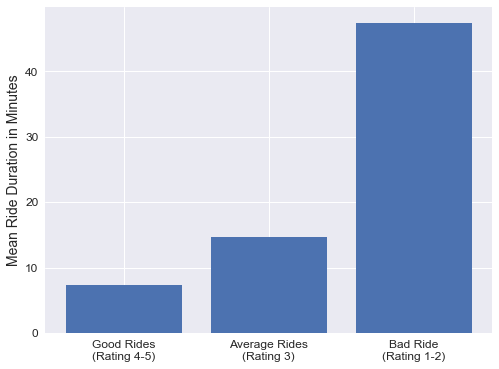

In [17]:
plt.figure(figsize=(8,6))
plt.bar([0, 1, 2],[good_rides.duration_minutes.mean(),
                   average_rides.duration_minutes.mean(),
                   bad_rides.duration_minutes.mean()])
plt.xticks([0, 1, 2], ('Good Rides\n(Rating 4-5)','Average Rides\n(Rating 3)','Bad Ride\n(Rating 1-2)'),fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Mean Ride Duration in Minutes',fontsize=14);

High rated rides tend to be around 7 minutes in length, average rides 15 minutes, and low rated rides over 60 minutes

Create a line plot that shows the number of near misses by the hour

In [18]:
x = df.groupby('start_hour')['num_near_misses'].sum().index.tolist()
y = df.groupby('start_hour')['num_near_misses'].sum().values.tolist()

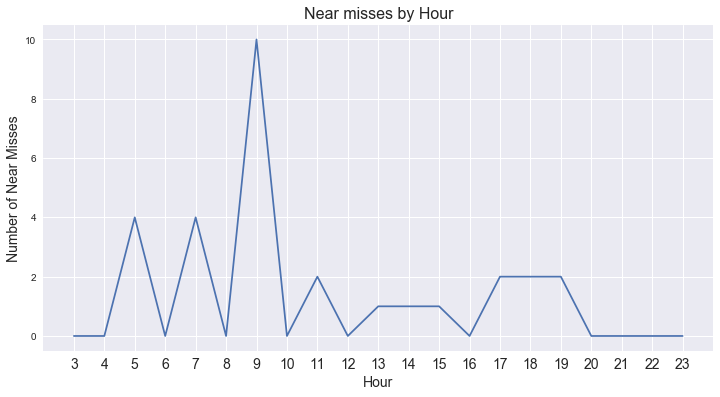

In [19]:
plt.figure(figsize=(12,6))
plt.plot(x, y)
plt.xticks(x, fontsize=14)
plt.xlabel('Hour',fontsize=14)
plt.ylabel('Number of Near Misses', fontsize=14)
plt.title('Near misses by Hour', fontsize=16)

Which cars have the most near misses?

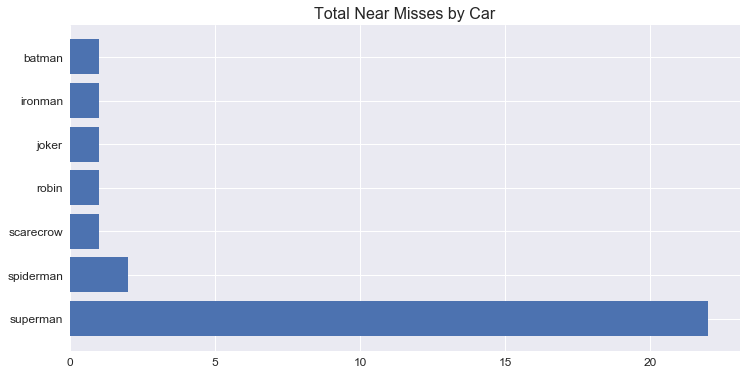

In [20]:
plt.figure(figsize=(12,6))
nearmiss_by_car = df.groupby('car_id')['num_near_misses'].sum().sort_values(ascending=False)
nearmiss_by_car = nearmiss_by_car[nearmiss_by_car > 0]
y = np.arange(nearmiss_by_car.shape[0])
x = nearmiss_by_car.values
plt.barh(y,x, align='center')
plt.title('Total Near Misses by Car', fontsize=16)
plt.yticks(y,nearmiss_by_car.index.values, fontsize=12)
plt.xticks(fontsize=12);

Create a plot comparing the number of stops made for each category of rides

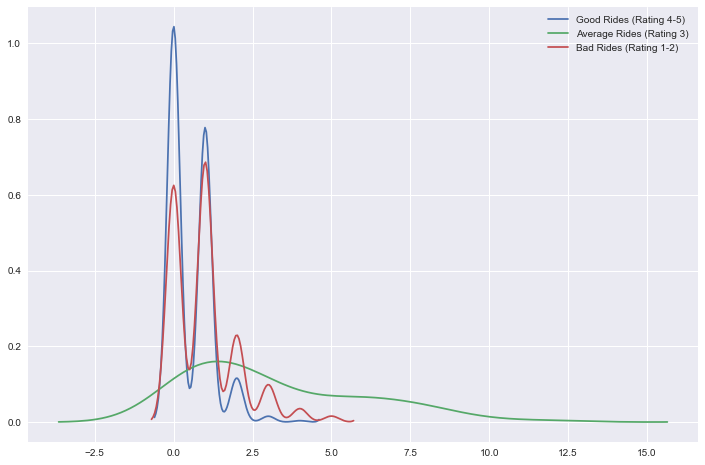

In [22]:
plt.figure(figsize=(12, 8))
sns.kdeplot(good_rides.num_stops, label = 'Good Rides (Rating 4-5)')
sns.kdeplot(bad_rides.num_stops, label = 'Average Rides (Rating 3)')
sns.kdeplot(average_rides.num_stops, label = 'Bad Rides (Rating 1-2)')

Business recommendations:
In this analysis, I'm assuming that ABC Company has a similar business model as Ride sharing companies like Uber and Lyft, where a user can request a ride from cars that are in the area. Like Uber and Lyft the user has the option to pool with other users.

That being said, my recommendations for this business are to:

1. Focus product development efforts on improving the car's ability to drive autonomously during times of heavy traffic. There are substantial peaks in near misses during the times where San Francisco typically experiences rush hour traffic, which is is around 7-9am in the morning (where the near misses are at its highest) and 4-7pm in the evening. https://www.quora.com/What-are-current-rush-hour-traffic-patterns-like-in-the-San-Francisco-Bay-Area. Since near misses with the superman car are the highest, I would suggest taking that car offline to be used for product development and testing and replace it with another car.  

2. The rides with the lowest ratings are typically rides that are more well over 20 minutes in length, sometimes well over an hour. I would recommend collecting feedback from these users to see what measures could be taken.
  - One place to look is the number of stops that are made en route to a destination. Rides with bad ratings tend to make many stops before dropping the user off. One of the worst rated rides made 12 stops before dropping the user off to his/her destination! This could be fixed by putting more cars out on the road to ensure that the rider demands are being met sufficiently.
  - Another thing to look at is if the cars are taking optimal routes to arrive at destinations. Maybe suggesting optimal pickup points for users would reduce the chance of the cars taking suboptimal paths and cut down the riding time.